In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import argparse
import logging

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="e017e289ac5444588b8048a596d10c57",
                                                           client_secret="9ee65b1a55b24c8eaf1e099c1544b724"))

import keras
import librosa
import music21

import matplotlib.pyplot as plt

from pathlib import Path
import IPython.display as ipd
from scipy.io import wavfile

In [ ]:
def json_extract(obj, key):
    """Recursively fetch values from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == key:
                    arr.append(v)
                elif isinstance(v, (dict, list)):
                    extract(v, arr, key)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    values = extract(obj, arr, key)
    return values

In [ ]:
# Helper functions to reduce code
def get_uri_df(playlist, offset, fields=['items.track.uri']):
    return pd.Series(json_extract(sp.playlist_tracks(playlist, fields=fields, offset=offset), 'uri'))

def clean_uris(uris):
    return uris[uris.str.contains('spotify:track:*')]

def get_feat_df(tracks, offset):
    data_batch = sp.audio_features(tracks=tracks[offset:offset+100])
    # return pd.DataFrame(data_batch).drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'key', 'duration_ms', 'time_signature'])
    return pd.DataFrame(data_batch)

def get_X_pca(pipeline, features_dict, genre):
    '''Helper function to transform X'''
    X = features_dict[genre].to_numpy()
    X_tr = pipeline['scaler'].transform(X)
    return pipeline['pca'].transform(X_tr)

## Grab spotify API data

In [ ]:
JAAR_LIST  = 'spotify:playlist:1nfPwrBDuzogouQHUSRNJU'    # pull from a playlist of Jaar's included works

uri_all = []
uri_all.append(get_uri_df(JAAR_LIST, offset=0))
# for i in range(0, 100, 10):
#     uri_batch = get_uri_df(JAAR_LIST, offset=i)
#     uri_all.append(uri_batch)

In [ ]:
tracks = pd.concat(uri_all).reset_index(drop=True).dropna()
tracks = tracks[tracks.str.contains('spotify:track:*')]

track_features_all = []
for i in range(0, tracks.size, 1):
    data_batch = sp.audio_features(tracks=tracks[i:i+1])
    df_track_features_batch = pd.DataFrame(data_batch)#.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'key', 'duration_ms', 'time_signature'])
    track_features_all.append(df_track_features_batch)

# Finalized, cleaned data for 10K songs
audio_features = pd.concat(track_features_all).reset_index(drop=True)
# audio_features.tail(10)

audio_features.columns
# tracks.size

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [ ]:
audio_features.drop(columns=['type', 'uri', 'track_href', 'analysis_url'])
# time_signature, key/mode, id
# audio_features_intro

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.416,0.323,0,-26.900,0,0.3160,0.831,0.00803,0.3560,0.2790,94.212,6wvihwMrXdqmkunqHro8gx,289054,3
1,0.616,0.152,0,-19.138,0,0.1980,0.807,0.76800,0.7440,0.0635,158.046,1Ui2wxssdwnfaZCwxxlW0J,202763,3
2,0.329,0.472,8,-20.199,1,0.0589,0.903,0.94300,0.1680,0.3360,79.390,3bbgUVYAfqPZdgQcptI9Sv,48488,5
3,0.741,0.202,4,-16.849,0,0.0466,0.871,0.62500,0.2660,0.2780,110.027,1db3rjzXv9NHjyyO6zVDSc,208425,4
4,0.836,0.379,7,-11.066,1,0.0605,0.148,0.88300,0.1020,0.3300,104.997,5fVxuymOckNzsc1LQCR72b,321791,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.666,0.446,1,-16.363,1,0.1160,0.145,0.81700,0.0816,0.8080,172.093,28tttimQIVzK8yZMb6XFG3,323500,4
62,0.389,0.337,0,-11.584,0,0.0751,0.473,0.85600,0.6140,0.0428,67.619,0NgggsA8qzWVITu4aFDWw7,975640,3
63,0.259,0.297,9,-10.531,0,0.0373,0.791,0.01940,0.1020,0.0416,98.057,3T0N9Bqvi4HtsMIv2rImfC,909037,5
64,0.227,0.421,10,-11.044,0,0.0588,0.672,0.08540,0.0973,0.0620,66.093,464vAL4t09lIqVFGCLmHU4,860160,4


## Grab all of the corresponding audio files

In [ ]:
!ls 'JaarSongs'

1-SpaceIsOnlyNoise(2011) 5-Cenizas(2020)          Pomegranates.jpg
2-Nymphs(2011-2015)      6-Telas(2020)            Sirens.jpg
3-Pomegranates(2015)     Cenizas.jpg              Space Is Only Noise.jpg
4-Sirens(2016)           Nymphs.jpg               Telas.jpg


In [ ]:
jaar_files = []
test_files = []

folder_path = Path('JaarSongs/1-SpaceIsOnlyNoise(2011)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

folder_path = Path('JaarSongs/2-Nymphs(2011-2015)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

folder_path = Path('JaarSongs/3-Pomegranates(2015)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

folder_path = Path('JaarSongs/4-Sirens(2016)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

folder_path = Path('JaarSongs/5-Cenizas(2020)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

folder_path = Path('JaarSongs/6-Telas(2020)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)


for file in jaar_files:
    print(file.name)

Space Is Only Noise-001-Nicolas Jaar-Être 1.wav
Space Is Only Noise-002-Nicolas Jaar-Colomb.wav
Space Is Only Noise-003-Nicolas Jaar-Sunflower.wav
Space Is Only Noise-004-Nicolas Jaar-Too Many Kids Finding Rain In the Dust.wav
Space Is Only Noise-005-Nicolas Jaar-Keep Me There.wav
Space Is Only Noise-007-Nicolas Jaar-Problem With the Sun.wav
Space Is Only Noise-008-Nicolas Jaar-Space Is Only Noise If You Can See.wav
Space Is Only Noise-009-Nicolas Jaar-Almost Fell.wav
Space Is Only Noise-010-Nicolas Jaar-Balance Her In Between Your Eyes.wav
Space Is Only Noise-011-Nicolas Jaar-Specters of the Future.wav
Space Is Only Noise-012-Nicolas Jaar-Trace.wav
Space Is Only Noise-013-Nicolas Jaar-Variations.wav
Space Is Only Noise-014-Nicolas Jaar-^tre.wav
Nymphs-001-Nicolas Jaar-Don't Break My Love.wav
Nymphs-002-Nicolas Jaar-Why Didn't You Save Me.wav
Nymphs-003-Nicolas Jaar-The Three Sides of Audrey and Why She's All Alone .wav
Nymphs-004-Nicolas Jaar feat Lorraine-No One Is Looking at U.wav


## Mid/side vs stereo

44100
[[ -1   0]
 [  0  -1]
 [ -1   0]
 ...
 [-17 -65]
 [-33 -24]
 [-86 -24]]
shapes:  (2, 6373632) (6373632,) (6373632,) (6373632, 2) (12747263, 2)
rates:  44100 22050


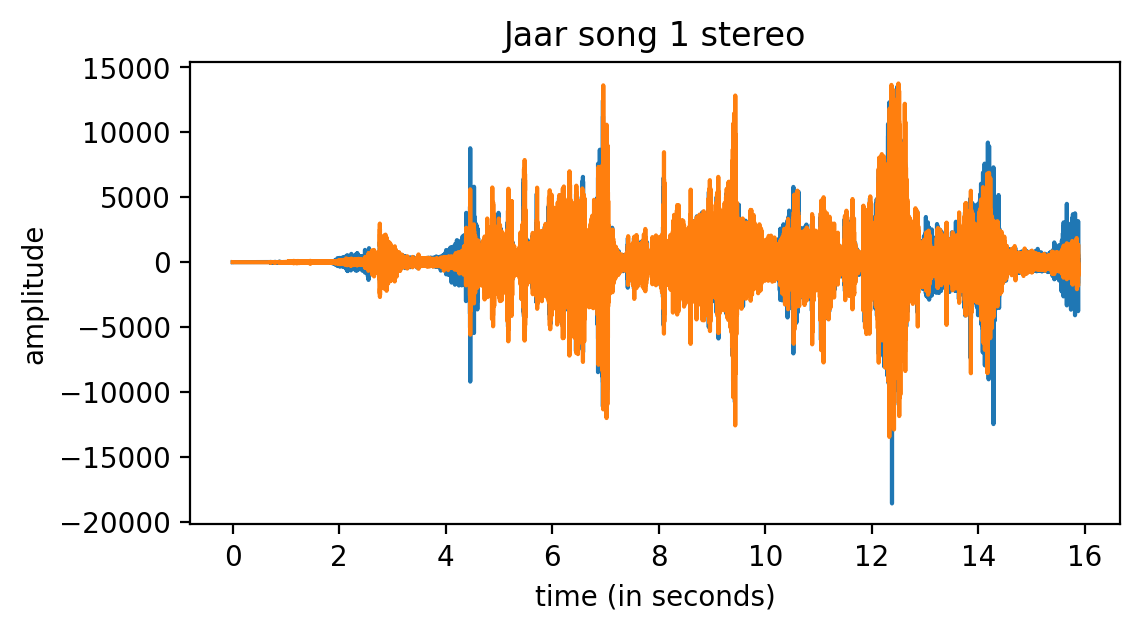

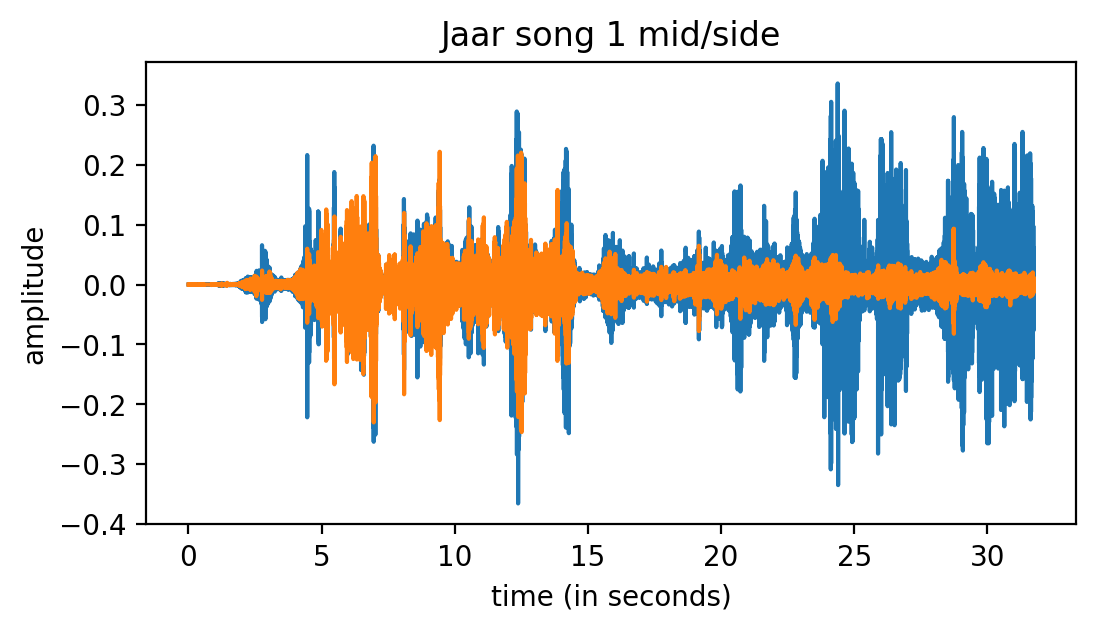

In [ ]:
y, sr = librosa.load(jaar_files[0], sr=22050, mono=False)
#y_mono = librosa.to_mono(y)
mid = 0.5 * (y[0, :] + y[1, :])
side = 0.5 * (y[0, :] - y[1, :])
MS = np.array([mid, side]).T


def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

### Modify the line below with your WAV file:
sample_rate, input_signal = wavfile.read(jaar_files[0])

print(sample_rate)
print(input_signal)
print('shapes: ', y.shape, mid.shape, side.shape, MS.shape, input_signal.shape)
print('rates: ', sample_rate, sr)

time_array = np.arange(0, len(input_signal)/sample_rate, 1/sample_rate)
setup_graph(title='Jaar song 1 stereo', x_label='time (in seconds)', y_label='amplitude', fig_size=(6,3))
_ = plt.plot(time_array[0:700000], input_signal[0:700000])

sample_rate, input_signal = sr, MS
time_array = np.arange(0, len(input_signal)/sample_rate, 1/sample_rate)
setup_graph(title='Jaar song 1 mid/side', x_label='time (in seconds)', y_label='amplitude', fig_size=(6,3))
_ = plt.plot(time_array[0:700000], input_signal[0:700000])

### Convert all of the files to mid-side in effort to aid with feature extraction

In [ ]:
import time

all_mid_side = []
sample_rate = 22050

start_time = time.time()
for i in range(len(jaar_files)):
    y, _ = librosa.load(jaar_files[i], sr=sample_rate, mono=False)
    mid = 0.5 * (y[0, :] + y[1, :])
    side = 0.5 * (y[0, :] - y[1, :])
    all_mid_side.append(np.array([mid, side]).T)
end_time = time.time()

print(end_time - start_time)

17.480773210525513


# Window slicing

### Comparison of different jaar songs

In [ ]:
raise Exception('Output omitted to reduce the file size')
print("Danceability rating of:", audio_features['danceability'][0])
ipd.Audio(librosa.load(jaar_files[0], sr=sample_rate, mono=False)[0], rate=sample_rate)

# first minute vs 1:30+

Exception: Output omitted to reduce the file size

In [ ]:
raise Exception('Output omitted to reduce the file size')
print("Danceability rating of:", audio_features['danceability'][33])
ipd.Audio(librosa.load(jaar_files[33], sr=sample_rate, mono=False)[0], rate=sample_rate)

Exception: Output omitted to reduce the file size

In [ ]:
raise Exception('Output omitted to reduce the file size')
print("Danceability rating of:", audio_features['danceability'][6])
ipd.Audio(librosa.load(jaar_files[6], sr=sample_rate, mono=False)[0], rate=sample_rate)

# First 30 compared to post 50

Exception: Output omitted to reduce the file size

#### And the lowest / highest ratings

In [ ]:
audio_features['danceability'].idxmax(), audio_features['danceability'].idxmin()

(5, 31)

In [ ]:
raise Exception('Output omitted to reduce the file size')
print("Top danceability rating of:", audio_features['danceability'][5])
ipd.Audio(librosa.load(jaar_files[5], sr=sample_rate, mono=False)[0], rate=sample_rate)

Exception: Output omitted to reduce the file size

In [ ]:
raise Exception('Output omitted to reduce the file size')
print("Lowest danceability rating of:", audio_features['danceability'][31])
ipd.Audio(librosa.load(jaar_files[31], sr=sample_rate, mono=False)[0], rate=sample_rate)

Exception: Output omitted to reduce the file size

### Actually split them

In [ ]:
# all_mid_side
#print(all_mid_side[0].shape)

window_sample_number = 30*sample_rate
#1323000

start_time = time.time()
all_mid_side_chopped = []
for i in range(len(all_mid_side)):
    offset = 0
    all_mid_side_chopped.append([])
    while offset + window_sample_number <= all_mid_side[i].shape[0]:
        all_mid_side_chopped[i].append(all_mid_side[i][offset : offset+window_sample_number, :])
        offset += window_sample_number
end_time = time.time()
print(end_time - start_time)
len(all_mid_side_chopped[0][0])

0.0008471012115478516


661500

In [ ]:
def count_nested_items(nested_list):
    count = 0
    stack = [nested_list]

    while stack:
        current_list = stack.pop()
        for item in current_list:
            if isinstance(item, list):
                stack.append(item)
            else:
                count += 1

    return count

# Example nested list
nested_list = all_mid_side_chopped

total_items = count_nested_items(nested_list)
print(f"Total items in the nested list: {total_items}")


Total items in the nested list: 650


### Index labels in correspondance with how many slices each song contains

In [ ]:
# Perhaps I want to normalize these between 0 and 1 - it might be better than leaving it as -1 to +1
#audio_features['danceability'].values are already scaled from 0 to 1

print(len(audio_features['danceability']), len(jaar_files)) #, len(test_files)

labels = []
for listI in range(len(all_mid_side_chopped)):
    for _ in all_mid_side_chopped[listI]:
        labels.append(audio_features['danceability'][listI])
print(len(labels))

### Expand the nested list of numpy arrays so that it is comparable to the label list's shape
x = []
for l in all_mid_side_chopped:
    for window in l:
        x.append(window)
print(len(x))

66 66
650
650


## Finally, export wav data as numpy arrays

In [ ]:
import pickle

labels = np.array(labels)
X = np.array(x)

print(labels.shape, X.shape)

with open('X_array_22050.pkl', 'wb') as file:
    pickle.dump(X, file)
with open('L_array_22050.pkl', 'wb') as file:
    pickle.dump(labels, file)

(650,) (650, 661500, 2)


### Some window comparisson

In [6]:
raise Exception('Output omitted to reduce the file size')
print("Mid of a random window" + " (danceability:", labels[89])
ipd.Audio(data=X[89,:,0], rate=sample_rate)

Exception: Output omitted to reduce the file size

In [7]:
raise Exception('Output omitted to reduce the file size')
print("Side of the same window")
ipd.Audio(data=X[89,:,1], rate=sample_rate)

Exception: Output omitted to reduce the file size

In [8]:
raise Exception('Output omitted to reduce the file size')
print("Mid of a another window" + " (danceability:", labels[200])
ipd.Audio(data=X[200,:,0], rate=sample_rate)

Exception: Output omitted to reduce the file size

In [9]:
raise Exception('Output omitted to reduce the file size')
print("Side of the same other window")
ipd.Audio(data=X[200,:,1], rate=sample_rate)

Exception: Output omitted to reduce the file size

In [ ]:
### Introduce the convolutional network's architecture
# Remember that the output is not a classifier and instead a numeric value

# I wish to try a parallel convolutional network... one where I take convolved mid info and convolved side info,
# and then concatenate them into more linear layers towards the end

# Actually, it might actually be interesting + worth trying stacking the input on top of itself... perhaps in time
# with the songs bpm or measures... that way, what is happenning can also be convolved with events further in the future

In [ ]:
### Train the model. Remember to use callbacks with keras
# My loss function does not have to be cross-entropy here.  Instead, I think I can just keep it simple with -1 and 1.
# Maybe would be interesting to try something that is a spectrum from -1 to 0 to +1, adjusting by my specified
# requirements.

In [ ]:
### Test the model and plot results
# Accuracy can be measured a number of ways here.  Could be percentage, where wrong is certain distance from correct
# answer.  Or just percentage based on overall distance from ground truth.  Or just loss.  Or some other arbitrary
# labelling method.